# Titanic 

In [64]:
from pathlib import Path
import os
from fastai.tabular.all import * 
import seaborn as sns

### Download dataset (if needed)

In [65]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    path = Path('../input/titanic')
    !pip install -Uqq fastai
else:
    import zipfile,kaggle
    path = Path('titanic')
    if not path.exists():
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

#### Minor pandas setup

In [66]:
pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

#### Minor seaborn setup

In [67]:
sns.set(rc={'figure.figsize':(6, 4)})

### Read & postprocess dataset

In [68]:
df = pd.read_csv(path/'train.csv')

In [69]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


#### Exploratory analysis

In [70]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,891.00,714.00,891.00,891.00,891.00
mean,446.00,0.38,2.31,29.70,0.52,0.38,32.20
std,257.35,0.49,0.84,14.53,1.10,0.81,49.69
min,1.00,0.00,1.00,0.42,0.00,0.00,0.00
25%,223.50,0.00,2.00,20.12,0.00,0.00,7.91
50%,446.00,0.00,3.00,28.00,0.00,0.00,14.45
75%,668.50,1.00,3.00,38.00,1.00,0.00,31.00
max,891.00,1.00,3.00,80.00,8.00,6.00,512.33


In [71]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


<Axes: xlabel='Fare', ylabel='Count'>

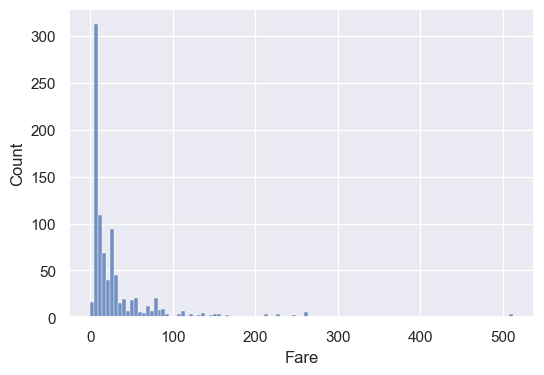

In [72]:
sns.histplot(df['Fare'])

<Axes: xlabel='Fare', ylabel='Count'>

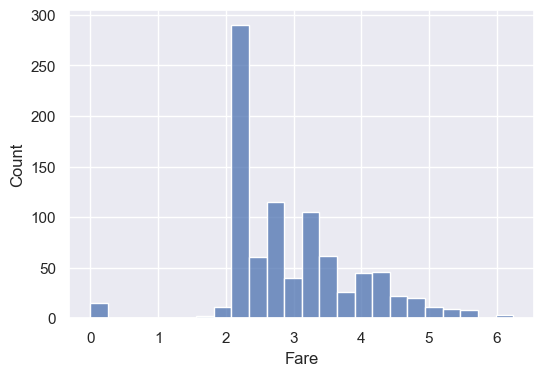

In [73]:
sns.histplot(np.log1p(df["Fare"]))

<Axes: xlabel='Pclass', ylabel='Survived'>

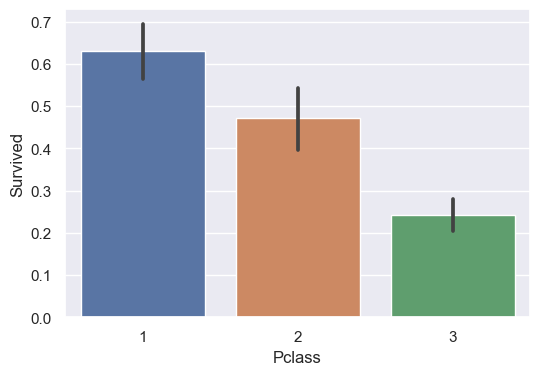

In [74]:
sns.barplot(x=df['Pclass'], y=df['Survived'])

/var/folders/zf/p75y8jj52c72dh5cv6ys92pm0000gn/T/ipykernel_24838/36101050.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = df.corr()


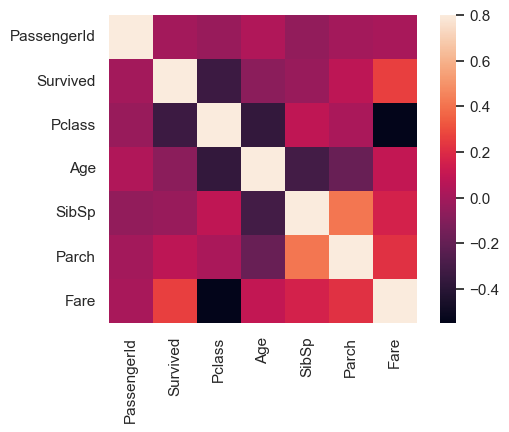

In [75]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(corrmat, vmax=.8, square=True);

#### Adding features

In [76]:
df["CabinZone"] = df["Cabin"].str[0]
df["LogFare"] = np.log1p(df["Fare"])
df["Family"] = df["SibSp"]+df["Parch"]
df["Title"] = df["Name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
df["Title"] = df["Title"].map(dict(Mr="Mr", Miss="Miss", Mrs="Mrs", Master="Master"))

#### Removing features

In [77]:
try:
    df.drop(["Name", "PassengerId", "Ticket", "Cabin"], axis=1, inplace=True)
except KeyError:
    pass

In [78]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,CabinZone,LogFare,Family,Title
0,0,3,male,22.00,1,0,7.25,S,NaN,2.11,1,Mr
1,1,1,female,38.00,1,0,71.28,C,C,4.28,1,Mrs
2,1,3,female,26.00,0,0,7.92,S,NaN,2.19,0,Miss
3,1,1,female,35.00,1,0,53.10,S,C,3.99,1,Mrs
4,0,3,male,35.00,0,0,8.05,S,NaN,2.20,0,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.00,0,0,13.00,S,NaN,2.64,0,NaN
887,1,1,female,19.00,0,0,30.00,S,B,3.43,0,Miss
888,0,3,female,NaN,1,2,23.45,S,NaN,3.20,3,Miss
889,1,1,male,26.00,0,0,30.00,C,C,3.43,0,Mr


### Machine Learning 

#### Validation dataset

In [61]:
splits = RandomSplitter(seed=42)(df)

#### DataLoader

In [79]:
dls = TabularPandas(
    df, 
    splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["Sex","Pclass","Embarked","CabinZone", "Title"],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Family'],
    y_names="Survived", y_block = CategoryBlock(),
).dataloaders(path=".")

#### Model definition

In [80]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

SuggestedLRs(slide=0.10000000149011612, valley=0.010964781977236271)

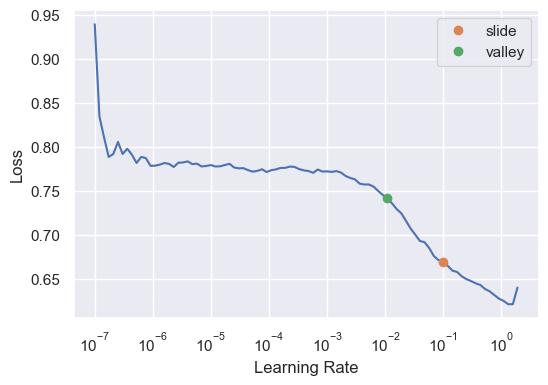

In [81]:
learn.lr_find(suggest_funcs=(slide, valley))

learn.fit(16, lr=0.05)

#### Testing

In [89]:
df = pd.read_csv(path/'test.csv')

In [90]:
df['Fare'] = df.Fare.fillna(0)

In [91]:
df["CabinZone"] = df["Cabin"].str[0]
df["LogFare"] = np.log1p(df["Fare"])
df["Family"] = df["SibSp"]+df["Parch"]
df["Title"] = df["Name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
df["Title"] = df["Title"].map(dict(Mr="Mr", Miss="Miss", Mrs="Mrs", Master="Master"))

In [94]:
tst_dl = learn.dls.test_dl(df)

In [95]:
preds,_ = learn.get_preds(dl=tst_dl)

In [97]:
df['Survived'] = (preds[:,1]>0.5).int()
sub_df = df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)